In [3]:
import requests
import pandas as pd
import certifi
import json
from urllib.request import urlopen
from datetime import datetime
import time
import pandas_ta as ta
import numpy as np

In [4]:

def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

In [5]:
def Get_Signal(data):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df_init.sort_values(by = 'date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    #df_init.dropna(subset=['SMA120'],inplace=True)
    #df_init.dropna(subset=['SMA120'],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    #df_init['signal'] = np.nan 
    # trigger a buy only if it is a up trend 
    #df_init.loc[(df['adjClose']>=df[variable_lower])&(df[variable_lower]>=df[variable_upper]) ,'Signal'] = 1
    
    # just triggered sell as close is less than variable triggered
    df_init.loc[(df_init['HoldRecordDate']=='Yes') ,'Signal'] = 1
    df_init.loc[df_init['date'] == df_init['date'].min(),'Signal'] == 1
    #df_init.loc[((df_init['uptrend']==False) ) ,'Signal'] = -1
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['Signal'] = df_init['Signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.date == i,'Signal'] = 1 
        else:
            
    
            #print(prev)
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[(df_init.date == prev),'Signal'].values[0]==-1):
                df_init.loc[df_init.date == i,'Signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[(df_init.date == prev)  ,'Signal'].values[0]==1):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==2)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]!=-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==0)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]==-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init

In [68]:
from statistics import mean
import datetime 
import math
# data = dataframe with signal
# capital = ur starting capital
def backtest_strategy(data,capital):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('date',inplace=True) 
    df_init.index = pd.to_datetime(df_init.index)
    #assign dummy row - day before the trade
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()

        # if signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'Signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif (df_init.loc[(df_init.index==date), 'Signal'].values[0] == 1) | ((df_init.loc[(df_init.index==date), 'Signal'].values[0] == 2)&(df_init.loc[(df_init.index==date), 'Price'].values[0]<18)):
            trade+=1
            start_cap = port_value 
            unit_buy = math.floor(port_value/df_init.loc[(df_init.index==date), 'Price'].values[0])
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'dividendPay'] = unit_buy*df_init.loc[(df_init.index==date), 'dividend'].values[0]   
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0] + df_init.loc[(df_init.index==date), 'dividendPay']        
        elif ((df_init.loc[(df_init.index==date), 'Signal'].values[0] == 2)&(df_init.loc[(df_init.index==date), 'Price'].values[0]>=18)):
            trade+=1
            start_cap = port_value 
            unit_buy = math.floor(port_value/df_init.loc[(df_init.index==date), 'Price'].values[0])
            df_init.loc[(df_init.index==date), 'units'] =   df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'dividendPay'] = unit_buy*df_init.loc[(df_init.index==date), 'dividend'].values[0]   
            df_init.loc[(df_init.index==date), 'cash'] = df_init.loc[(df_init.index==date), 'dividendPay']+ df_init.loc[(df_init.index==prev_date), 'cash'].values[0]   
        #if we have a hold signal or do nothing signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
#         elif ((df_init.loc[(df_init.index==date), 'Signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'Signal'].values[0] == 0)): 
#             df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
#             df_init.loc[(df_init.index==date), 'dividendPay'] = unit_buy*df_init.loc[(df_init.index==date), 'dividend'].values[0]
#             df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0] + unit_buy*df_init.loc[(df_init.index==date), 'dividend'].values[0]
        
        #if we have a sell signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'Signal'].values[0] == -1):
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v> 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    return total_port_value, df_init

In [7]:
api = 'oX1sBTfvsAn0ALsUptoRGJCxFlY2iXCA'

In [8]:
ticker_Select = 'QYLD'
daily_stock_link = 'https://financialmodelingprep.com/api/v3/historical-price-full/'+ticker_Select+'?from=2015-01-01&=&apikey='+api
daily_stock = get_jsonparsed_data(daily_stock_link )
daily_stock = pd.json_normalize(daily_stock['historical'])
daily_stock = daily_stock.sort_values(by=['date'])
daily_stock['Symbol'] = ticker_Select


C:\Users\CHIN\AppData\Local\Temp/ipykernel_21560/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [9]:
dividend_link = 'https://financialmodelingprep.com/api/v3/historical-price-full/stock_dividend/'+ticker_Select+'?apikey='+api
dividend_stock = get_jsonparsed_data(dividend_link )
dividend_stock = pd.json_normalize(dividend_stock['historical'])
dividend_stock = dividend_stock.sort_values(by=['date'])
dividend_stock['symbol'] = ticker_Select

C:\Users\CHIN\AppData\Local\Temp/ipykernel_21560/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [10]:
daily_stock['HoldRecordDate'] = 'Yes'

In [11]:
dividend_stock = pd.merge(dividend_stock,daily_stock[['date','HoldRecordDate']], left_on = ['recordDate'], right_on = ['date'], how='left')

In [12]:
daily_stock = pd.merge(daily_stock.drop(['HoldRecordDate'],axis=1),dividend_stock[['paymentDate','dividend','HoldRecordDate']], right_on= ['paymentDate'], left_on = ['date'],how='left')

In [13]:
daily_stock = Get_Signal(data=daily_stock)

In [18]:
daily_stock['Price'] = daily_stock['close']

In [15]:
daily_stock['dividend'].fillna(0,inplace=True)

In [29]:
total , daily_stock_holding = backtest_strategy(daily_stock,capital=1000)

In [33]:
daily_stock_holding.reset_index().to_csv('dailyStockHolding.csv',index=False)

In [69]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [71]:
import matplotlib.pyplot as plt
# Get signal
# back test your strategy using Open price as price action to buy sell on particular day
daily_stock['Price']=daily_stock['open']
df_backtest = daily_stock.copy()
result, hold_detail = backtest_strategy(df_backtest,1000)
# calculate the return without trailing of hold without sell 
hold_detail['hold_without_sell_return (%)'] = daily_stock['close']/daily_stock['close'].iloc[0]*100
result['hold_without_sell_return (%)'] = daily_stock.set_index('date')['hold_without_sell_return (%)']
result = result.reset_index().rename(columns = {'index':'date'})

Annualized_return of best strategy: 13.62859028206833
MDD of best strategy: -21.791051780846406


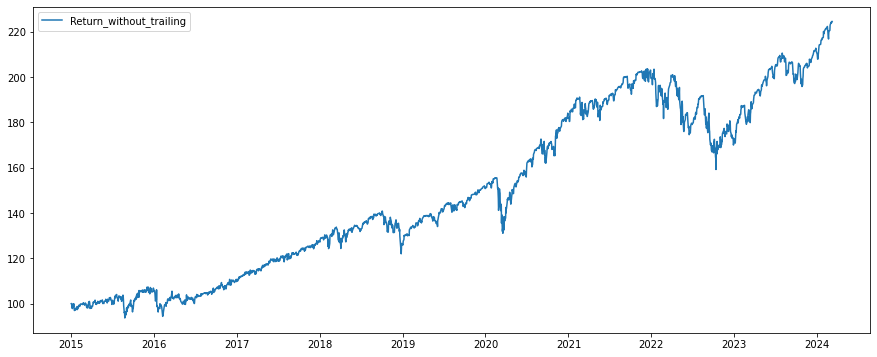

In [72]:
# plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(result.set_index('date').Return_without_trailing, label='Return_without_trailing')
# plt.plot(result['hold_without_sell_return (%)'], label='Return without trailing of hold without sell')
plt.legend()
print('Annualized_return of best strategy:',annualized (result,'Return_without_trailing'))
print('MDD of best strategy:', MDD(result,'Return_without_trailing'))

# print('Annualized_return of hold without sell:',annualized (result,'hold_without_sell_return (%)'))
# print('MDD of hold without sell:', MDD(result,'hold_without_sell_return (%)'))
# # calculate the return without trailing of hold without sell 
# # plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
# plt.rcParams["figure.figsize"] = (15,6)
# plt.plot(total.Return_without_trailing, label='Return without trailing')
# plt.legend()
# print('Annualized_return of best strategy:',annualized (result,'Return_without_trailing'))
# print('MDD of best strategy:', MDD(result,'Return_without_trailing'))

# print('Annualized_return of hold without sell:',annualized (result,'hold_without_sell_return (%)'))
# print('MDD of hold without sell:', MDD(result,'hold_without_sell_return (%)'))

In [73]:
hold_detail.to_csv('hold_detail.csv')